In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import segmentation_models as sm
import gc
from pipeline import Pipeline
import matplotlib.pyplot as plt
from tqdm import tqdm

2023-05-20 09:10:35.360340: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


Segmentation Models: using `keras` framework.


## Load the test set, build the pipeline

In [3]:
data_dir = "./dataset/"
patch_size = 800  # e.g. 128x128
downsampling = 1  # setting this to e.g. 0.5 means images will be loaded as 2x smaller. 1 does nothing.
z_dim = 40   # number of slices in the z direction. max value is 65 - z_start
z_start = 0  # offset of slices in the z direction
batch_size = 4
epochs = 100
steps_per_epoch = 50
val_step = 50
backbone = 'resnet18'

pipeline = Pipeline(data_dir, patch_size, downsampling, z_dim, z_start, batch_size)

volume_a, mask_a, _ = pipeline.load_sample(split="test", index='a')
volume_a = sm.get_preprocessing(backbone)(volume_a)

volume_b, mask_b, _ = pipeline.load_sample(split="test", index='b')
volume_b = sm.get_preprocessing(backbone)(volume_b)

volume_3, mask_3, labels_3 = pipeline.load_sample(split="train", index='3')
volume_3 = sm.get_preprocessing(backbone)(volume_3)

# volume_1, mask_1, labels_1 = pipeline.load_sample(split="train", index='1')
# volume_1 = sm.get_preprocessing(backbone)(volume_1)


gc.collect()
print("Loading complete.")

Loading 'test/a'...


100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


Loading 'test/b'...


100%|██████████| 4/4 [00:17<00:00,  4.39s/it]


Loading 'train/3'...


100%|██████████| 4/4 [00:20<00:00,  5.03s/it]


Loading complete.


## Load Model and Checkpoint

In [5]:
CHECKPOINT_PATH = 'chkpt/resnet18-800p-4b-clahe-chkpt'
CHECKPOINT_NAME = 'resnet18-800p-4b-180epoch'

model = sm.Unet(
    'resnet18',
    input_shape=pipeline.get_input_shape(),
    encoder_weights=None,
    classes=1
)

model.load_weights(f'{CHECKPOINT_PATH}/checkpoint')

2023-05-20 09:18:34.425256: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-05-20 09:18:34.802208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-20 09:18:34.802407: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2023-05-20 09:18:34.802446: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2023-05-20 09:18:34.830684: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2023-05-20 09:18:34.851140: I tensorflow/stream_executor/plat

## Predict and Assemble

In [9]:
from train_utils import predict_and_assemble

threshold = 0.95
all_pred_3, all_binary_pred_3, pred_3 = predict_and_assemble(pipeline, volume_3, mask_3, threshold, model)
# all_pred, all_binary_pred, pred = predict_and_assemble(pipeline,volume_1, mask_1, threshold, model)
all_pred_a, all_binary_pred_a, pred_a = predict_and_assemble(pipeline, volume_a, mask_a, threshold, model)
all_pred_b, all_binary_pred_b, pred_b = predict_and_assemble(pipeline, volume_b, mask_b, threshold, model)

Iterated dataset size: 154


0it [00:00, ?it/s]2023-05-20 09:25:11.525787: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.8
2023-05-20 09:25:18.210151: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
154it [00:39,  3.93it/s]


Iterated dataset size: 47


47it [00:09,  4.99it/s]


Iterated dataset size: 102


102it [00:20,  4.97it/s]


## Plot the result

#### Volume 3

Text(0.5, 1.0, 'Binary Predictions')

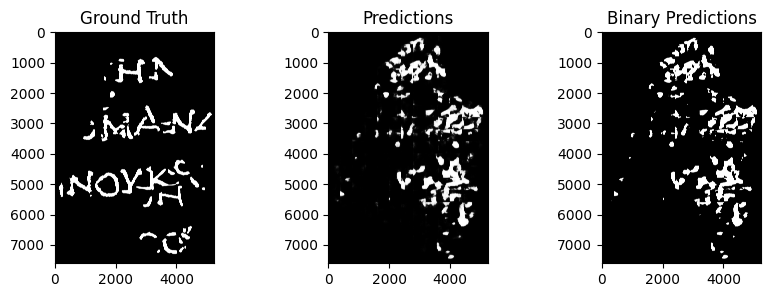

In [15]:
threshold = 0.5
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(labels_3, cmap='gray')
axs[0].set_title("Ground Truth")
axs[1].imshow(all_pred_3, cmap='gray')
axs[1].set_title("Predictions")
axs[2].imshow(all_pred_3 > threshold, cmap='gray')
axs[2].set_title(f'Binary Predictions')
# plt.savefig(f'imgs/{CHECKPOINT_NAME}-threshold-{threshold}-volume-3-compare.svg')

#### Test a

Text(0.5, 0.98, 'Predictions on test set a')

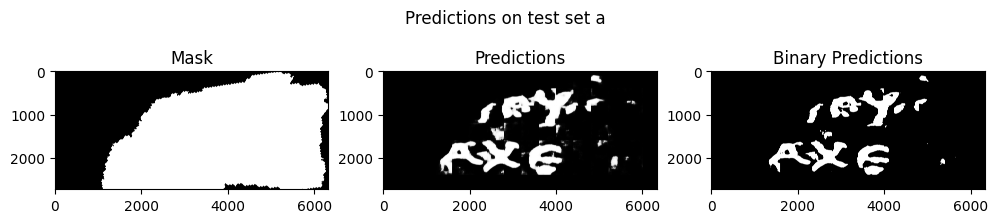

In [12]:
threshold = 0.95
fig, axs = plt.subplots(1, 3, figsize=(12, 2.5))
axs[0].imshow(mask_a, cmap='gray')
axs[0].set_title("Mask")
axs[1].imshow(all_pred_a, cmap='gray')
axs[1].set_title("Predictions")
axs[2].imshow(all_pred_a > threshold, cmap='gray')
axs[2].set_title(f'Binary Predictions')
fig.suptitle("Predictions on test set a")
# plt.savefig(f'imgs/{CHECKPOINT_NAME}-threshold-{threshold}-test-a-compare.svg')

#### Test b

Text(0.5, 0.98, 'Predictions on test set b')

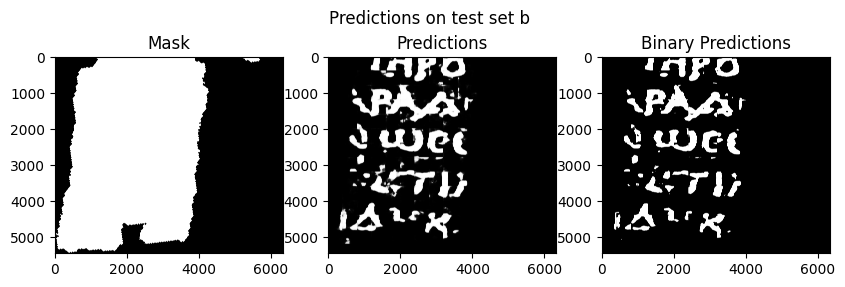

In [13]:
threshold = 0.95
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(mask_b, cmap='gray')
axs[0].set_title("Mask")
axs[1].imshow(all_pred_b, cmap='gray')
axs[1].set_title("Predictions")
axs[2].imshow(all_pred_b > threshold, cmap='gray')
axs[2].set_title(f'Binary Predictions')
fig.suptitle("Predictions on test set b")
# plt.savefig(f'imgs/{CHECKPOINT_NAME}-threshold-{threshold}-test-b-compare.svg')

## Submission file

In [16]:
def rle(output):
    flat_img = np.where(output.flatten() > 0.5, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

In [17]:
submission = defaultdict(list)

submission["Id"].append("a")
submission["Predicted"].append(rle(all_pred_a))
submission["Id"].append("b")
submission["Predicted"].append(rle(all_pred_b))

pd.DataFrame.from_dict(submission).to_csv(f'submission/submission-{CHECKPOINT_NAME}.csv', index=False)

In [18]:
df = pd.DataFrame.from_dict(submission)
df

,Id,Predicted
0,a,612552 10 618870 24 625196 30 631522 37 637849...
1,b,1331 120 1752 146 2156 170 2481 489 3202 18 34...
